<a href="https://colab.research.google.com/github/WEBAAA3/experimentos/blob/main/T_Net_LossChamferDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Verificar os códigos para instalação da libs

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
#from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageOps
import time
import os
import time
from glob import glob
import plotly.graph_objects as go


%matplotlib inline


In [ ]:
#from torchinfo import summary


In [ ]:
#from torchsummary import summary

In [ ]:
#pip install tensorboardcolab

In [ ]:
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
# tbc = TensorBoardColab()

# %load_ext tensorboard

In [ ]:
pip install chamferdist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for chamferdist: filename=chamferdist-1.0.0-cp37-cp37m-linux_x86_64.whl size=2634251 sha256=0332c97f7a009a5205a7314a3ea34d5234e423f724d271523c774bb8896db3dc
  Stored in directory: /root/.cache/pip/wheels/28/bb/d1/c789ecd6835e466e813f6e2c5e23bb1bbb2248e84586ba82d2
Successfully built chamferdist


In [ ]:
from chamferdist import ChamferDistance as chamfer_dist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001
BATCH_SIZE = 10

HEIGHT = 43
WIDTH = 10
RGBA = 4
RGB = 3
GRAY = 1
NUM_POINTS = 102
DIAMETRO_TUBULACAO = 10

#shuffle = True
DIR_DATA = '/content/drive/MyDrive/Minha_CNN/data/data10partes/paleta01'
DIR_GT = '/content/drive/MyDrive/Minha_CNN/gtcloudpoints/gt_10partes102pontos'
DIR_PREDICT = '/content/drive/MyDrive/Minha_CNN/predict/pred_10partes/'
FILE_DATA = '/content/drive/MyDrive/Minha_CNN/data/data10partes/paleta01/data_com_vdbaixo.csv'
#FILE_DATA = '/content/drive/MyDrive/Minha_CNN/data/data10partes/paleta01/data_aug.csv'
FILE_WEIGHT = '/content/drive/MyDrive/Minha_CNN/weights/wg_10partes/'
DIR_NORMALIZACAO = '/content/drive/MyDrive/Minha_CNN/scripts_preprocessamento/verificaNormalizacao'
FIXA_XY = '/content/drive/MyDrive/Minha_CNN/fixaXY.csv'

# **Pré processamento dos dados**

In [ ]:
def preprocess(img, pointcloud):
    img = PIL.ImageOps.grayscale(PIL.Image.open(img))
    img_np = (np.array(img, dtype='float32')) / 255
    #img_np = np.array(img, dtype='float32')
    im_resized = img_np.reshape(WIDTH, HEIGHT)
    tensor_image = torch.tensor(im_resized, dtype=torch.float32)
    df = pd.read_csv(pointcloud, sep=" ", header=None, names=["x", "y", "z"])
    #df = df/df.max() # Normalização do dataframe
    df =  df/df.max()
    tensor_pointcloud = torch.tensor(df.values, dtype=torch.float32)

    return (tensor_image, tensor_pointcloud)

# **Obtendo os dados de entrada + ground truth**

In [ ]:
class ThermalDataset(Dataset):

    def __init__(self, dataframe, dir_data, dir_gt, transform=None):
        self.dir_data = dir_data
        self.dir_gt = dir_gt
        self.img_loads = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.img_loads)

    def __getitem__(self, idx):
        file_img = os.path.join(self.dir_data, self.img_loads.iloc[idx, 0])
        file_pointcloud = os.path.join(self.dir_gt, self.img_loads.iloc[idx, 1])
        tensor_img, tensor_filepointcloud = preprocess(file_img, file_pointcloud)
        return (tensor_img, tensor_filepointcloud)

# **Tamanho da imagem após as convoluções:**

*   O = Largura da imagem de saída
*   I = Largura da imagem de entrada (válido para altura da imagem)
*   K = Largura do Kernel da Conv Layer
*   N = Número de Kernels.
*   S = Stride da operação de convolução
*   P = Padding




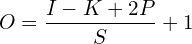

fonte: https://learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/

Minha imagem
>

*   altura = 90 pixeis
*   largura = 25 pixeis
*   kernel = 3 (3x3)
*   Stride = 1
*   Padding = 0




Altura da imagem na saída da convolução = (((90 - 3) + 2(0))/1) + 1 = 88

Largura da imagem na saída da convolução = (((25 - 3) + 2(0))/1)) + 1 = 23

Desta forma na primeira convolução entrarei com uma imagem 90 alt x 25 larg x 1 canal (tons de cinza), após a convolução terei 16 pequenas imagens (= 16 canais = profundidade) de 88 alt x 23 larg.
Importante mencionar que o tamanho de saída de uma camada convolucional será o tamanho de entrada da camada posterior. Isto é, a saída de uma camada será a entrada da próxima camada.


# **Tamanho da saída da deconvolução =  ConvTranspose2d**



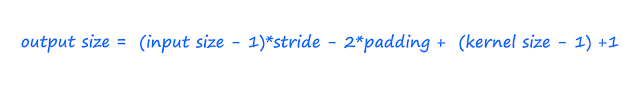

[Stanford University - Reconstrução 3D](http://graphics.stanford.edu/courses/cs468-17-spring/LectureSlides/L14%20-%203d%20deep%20learning%20on%20point%20cloud%20representation%20(analysis).pdf)

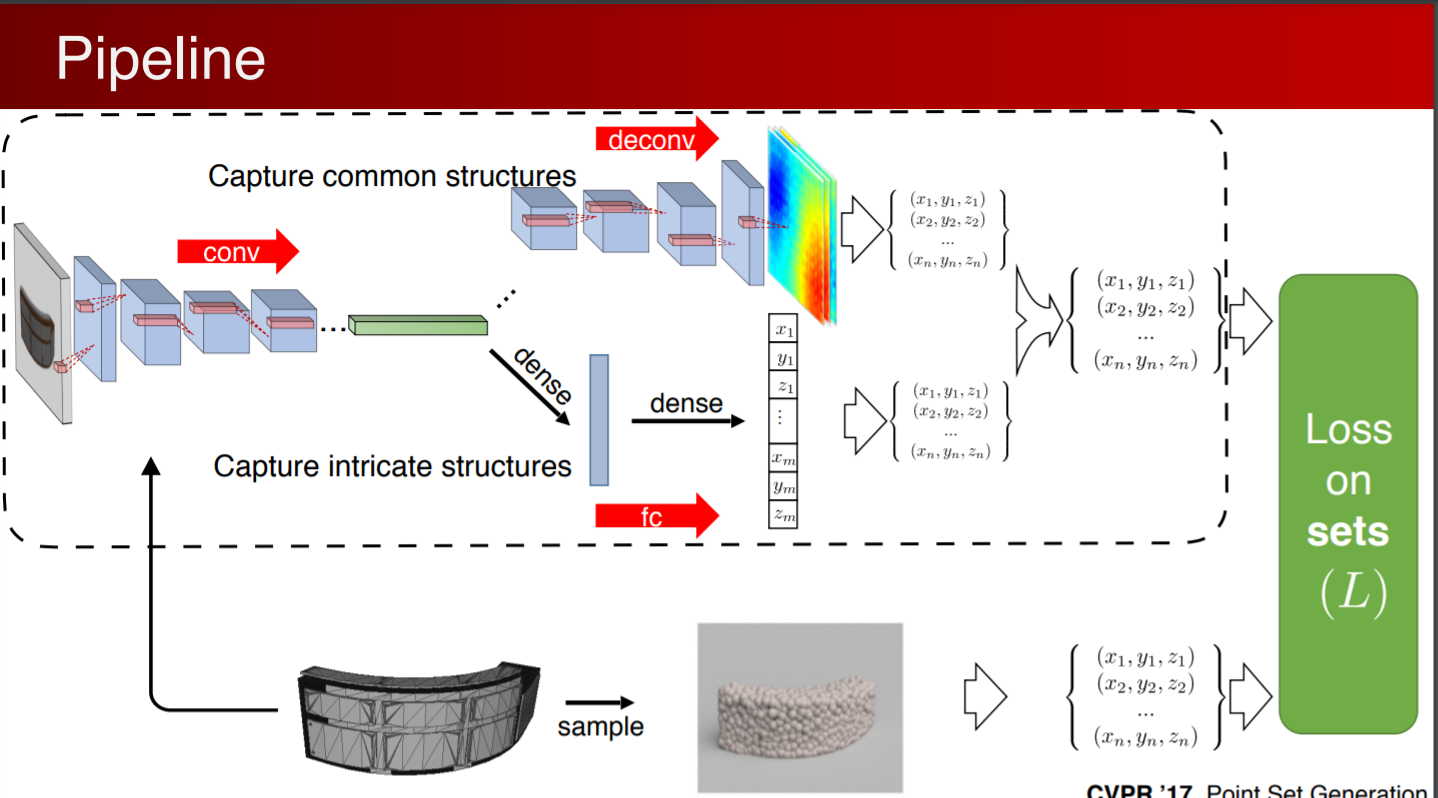


In [ ]:
class ThermalNet(nn.Module):

    def __init__(self, x=input):
        super(ThermalNet, self).__init__()
        # Encoder
        self.encoder_4x16     = nn.Conv2d(in_channels=1,   out_channels=16,   kernel_size=(2,2), stride=(1, 1), padding=0) #conv1 9*42
        self.enc_4x16_bn      = nn.BatchNorm2d(16)
        self.maxpool          = nn.MaxPool2d(2, stride=2, padding=1) # maxpool 5*21
        self.encoder_16x32    = nn.Conv2d(in_channels=16,  out_channels=32,   kernel_size=(2,2), stride=(1, 1), padding=0) #conv2 4*20
        self.enc_16x32_bn     = nn.BatchNorm2d(32)
        self.maxpool          = nn.MaxPool2d(2, stride=2, padding=1) # maxpool 3*10
        # Fully conected na saída do encoder
        self.enc_fc1  = nn.Linear(in_features= 32*10*10, out_features=1024) #32*10*3 = nro de canais saida X altura img X largura img
        self.enc_fc2  = nn.Linear(in_features=1024, out_features=512)
        self.enc_fc3  = nn.Linear(in_features=512, out_features=306)   # alteração da saida de 306 para 102 neuronios
        # Decoder
        self.decoder_32x16    = nn.ConvTranspose2d(in_channels=32,   out_channels=16,  kernel_size=3, padding = 0) #deconv3 5*12
        self.dec_32x16_bn     = nn.BatchNorm2d(16)
        self.decoder_16x3     = nn.ConvTranspose2d(in_channels=16,   out_channels=3,  kernel_size=3, padding = 0) #deconv4 7*14
        self.dec_16x3_bn      = nn.BatchNorm2d(3)
        # forcei o término da rede com 3 canais para validar a descrição do paper
        # onde o primeiro canal tem as coordenadas x, segundo canal coord y, terceiro canal coord z
        # Fully conected na saída do decoder
        self.dec_fc1  = nn.Linear(in_features= 3*14*5, out_features=1024) # 3*14*7 = nro de canais saida X altura img X largura img
        self.dec_fc2  = nn.Linear(in_features=1024, out_features=512)
        self.dec_fc3  = nn.Linear(in_features=512, out_features=306) # alteração da saida de 306 para 102 neuronios

    def forward(self, x):
        #print("-------------Entrei no forward---------------------")
        # encoder
        x = torch.relu(self.enc_4x16_bn(self.encoder_4x16(x)))
        #print(f"encoder_4x16    (shape) {x.shape}")
        x=F.max_pool2d(x,2)
        #print(f"encoder_4x16 depois do maxpooling   (shape) {x.shape}")
        x = torch.relu(self.enc_16x32_bn(self.encoder_16x32(x)))
        #print(f"encoder_16x32   (shape) {x.shape}")
        x=F.max_pool2d(x,2)
        #print(f"encoder_16x32 depois do maxpooling   (shape) {x.shape}")
        enc_out = x.clone().detach().requires_grad_(True) # copia o valor de um tensor X para outro tensor pq preciso dos valores originais de X para o decoder
        #print(f"copia do x = enc_out   (shape) {enc_out.shape}")
        x_encoder_fc = torch.relu(self.enc_fc1(enc_out.reshape(-1, 32*10*10)))
        #print(f"enc_fc1     (shape) {x_encoder_fc.shape}")
        x_encoder_fc = torch.relu(self.enc_fc2(x_encoder_fc))
        #print(f"enc_fc2     (shape) {x_encoder_fc.shape}")
        x_encoder_fc = torch.relu(self.enc_fc3(x_encoder_fc))
        #print(f"enc_fc3     (shape) {x_encoder_fc.shape}")
        # decoder
        x = torch.relu(self.dec_32x16_bn(self.decoder_32x16(x)))
        #print(f"decoder_32x16    (shape) {x.shape}")
        x = torch.relu(self.dec_16x3_bn(self.decoder_16x3(x)))
        #print(f"decoder_16x3     (shape) {x.shape}")
        x = torch.relu(self.dec_fc1(x.reshape(-1, 3*5*14)))
        #print(f"dec_fc1     (shape) {x.shape}")
        x = torch.relu(self.dec_fc2(x))
        #print(f"dec_fc2     (shape) {x.shape}")
        x = torch.relu(self.dec_fc3(x))
        #print(f"dec_fc3     (shape) {x.shape}")
        t_out = torch.relu(x_encoder_fc.add(x))# esta saida tem 306 neuronios
        #print(t_out)
        #tensorXYZ = t_out.reshape([1,-1]).squeeze()
        tensorXYZ = t_out.reshape([BATCH_SIZE, NUM_POINTS, 3]) #reshape na saida para igualar ao formato do arquivo da nuvem de pontos
        #tensorXYZ = t_out.reshape([BATCH_SIZE, NUM_POINTS]) #reshape na saida para igualar ao formato do arquivo da nuvem de pontos
        #print(f"Saída da CNN tensorXYZ = {tensorXYZ.shape}")

        return tensorXYZ



# ** ------------------ INICIO ----------------------**

In [ ]:
df = pd.read_csv(FILE_DATA, delimiter=";")

In [ ]:
dataset = ThermalDataset(dataframe=df, dir_data=DIR_DATA, dir_gt=DIR_GT, transform=None)
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [60, 20, 20])
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
# valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE)
# test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#print(f" Passei do dataloader number of train images = {len(train_data)} & number of test images = {len(test_data)}")

In [ ]:
model = ThermalNet(x=input)

In [ ]:
#print("Model state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# print("Optimizer state_dict:")

# torch.save(model.state_dict(), 'model_weights.pth')
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=0) #, amsgrad=False
loss_ChamferDist = chamfer_dist()
#criterion = nn.MSELoss() # ATENÇÃO caso mude o criterio da Loss verificar outras partes do codigo
criterion = chamfer_dist()
# lambda1 = lambda epoch: 0.65 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [ ]:
min_valid_loss = np.inf
print(np.inf)

inf


In [ ]:
source_cloud = torch.randn(1,102,3)
print(source_cloud.shape)


torch.Size([1, 102, 3])


In [ ]:
print(source_cloud[0])
print(source_cloud[0, 1, 1])

tensor([[-1.9314,  2.7299,  0.4940],
        [-0.0510, -0.9638,  0.0755],
        [ 0.5112, -0.4726, -0.9023],
        [-0.3688, -0.3246,  0.6520],
        [ 0.8387, -1.1183,  1.3811],
        [-0.6742, -0.9163,  0.3423],
        [-0.4457,  0.2979,  0.3879],
        [ 0.9615,  1.2254,  0.0903],
        [-0.3761,  0.2209, -2.0695],
        [-0.9121,  1.0057,  0.2434],
        [-2.2269,  0.0983, -0.9738],
        [ 0.6954, -1.0917, -1.0635],
        [ 0.3423, -0.7161, -1.6124],
        [ 0.6338,  0.0891,  1.5671],
        [ 0.8229, -0.2654, -0.3938],
        [ 0.6134,  0.0233, -1.7044],
        [-0.9134, -1.7866,  1.7088],
        [-1.2282,  1.3608, -1.5853],
        [-0.1822,  0.0306,  0.5538],
        [-0.2827,  0.8187, -0.8262],
        [-2.6812,  1.0136, -0.6201],
        [ 1.3165,  2.7121, -0.8636],
        [ 0.8047,  0.1364, -0.8197],
        [ 0.4109, -1.2501,  0.2423],
        [-1.4151,  0.2802, -0.0154],
        [ 0.3623,  0.7579,  3.1826],
        [-0.0156, -1.1749,  1.4587],
 

In [ ]:
  for t in range(predict.shape[0]):
    z_pred  = predict[t,0:predict.shape[1]].detach().numpy()

In [ ]:
print(source_cloud)

tensor([[[ 0.5299,  1.2085,  0.4900],
         [-0.9009,  0.2991, -1.6621],
         [ 1.6537, -1.4031,  0.9712],
         [-1.0760, -0.0617, -2.4564],
         [-0.4600,  1.0562,  1.2935],
         [ 1.9000,  1.3001,  0.1414],
         [-2.2338,  0.5785,  0.9218],
         [-1.0264,  1.4053, -0.2532],
         [-0.0633,  0.5683, -0.5906],
         [-1.2909,  0.8083, -1.1486],
         [ 1.9782, -2.2868, -1.3772],
         [ 0.8193, -1.2064, -0.8142],
         [-0.0968,  0.3981,  0.3261],
         [-0.0235,  0.6063, -0.4128],
         [ 2.8289,  1.1513,  0.3843],
         [-1.5621,  0.2427,  0.4867],
         [ 1.6200, -0.6138,  1.0774],
         [-2.0566,  1.2155, -0.3305],
         [-0.5453, -0.3172,  0.2528],
         [-0.2220, -0.4244, -0.1046],
         [ 0.4410,  0.6873,  0.3613],
         [-0.6001,  2.5281, -0.4721],
         [ 0.5497, -3.1610, -0.8348],
         [-0.9276, -0.2851,  0.3801],
         [-0.4675, -1.5164, -0.5542],
         [ 1.2763,  0.9934,  0.4395],
         [ 0

In [ ]:
t_colunas = [
    'epoca',
    'MSE',
    'RMSE',
    'MAE',
    'CD'
]
df_treino = pd.DataFrame(columns=t_colunas)

v_colunas = [
    'epoca',
    'valid_loss'
]
df_validacao = pd.DataFrame(columns=v_colunas)
t_index = 0
v_index = 0

for e in range(NUM_EPOCHS):
    print(f"[=================  Época {e}/{NUM_EPOCHS} \t {time.asctime( time.localtime(time.time()) )}  ==========================]")
    #print(time.asctime( time.localtime(time.time()) ))
    model.train()
    data_iter = iter(train_loader)
    i = 0
    train_loss = 0.0
    MSE   = 0.0
    RMSE  = 0.0
    MAE   = 0.0
    R2    = 0.0
    l_MSE  = []
    l_RMSE = []
    l_MAE  = []
    l_CD   = []
    while i < len(train_loader):
        data = data_iter.next()
        images, points = data
        img_aux = images.clone().detach().requires_grad_(True)
        images = img_aux.reshape(BATCH_SIZE, GRAY, WIDTH, HEIGHT) # ajustar as dimensões da imagem para entrar na CNN
        optimizer.zero_grad()
        predict = model(images)
        #print(f"Verificando o retorno do tensor da CNN predict = {predict.shape}")
        #print(f"Verificando o formato do tensor points.shape = {points.shape}")
        # --- ajustando os tensores para MSE, RMSE, MAE ---------------------
        points_metrics_error = points.reshape([1,-1]).squeeze()
        torch.unsqueeze(points_metrics_error, 1)
        predict_metrics_error = predict.reshape([1,-1]).squeeze()
        torch.unsqueeze(predict_metrics_error, 1)
        # print(f"predict_metrics_error.shape torch.unsqueeze(predict_metrics_error, -1) = {predict_metrics_error.shape}\n")
        # print(f"points_metrics_error.shape  torch.unsqueeze(points_metrics_error, -1)  = {points_metrics_error.shape}\n")
        loss_fn = criterion(predict, points)
        loss_fn.backward()
        optimizer.step()
        train_loss += loss_fn.item()

        MSE  = mean_squared_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy())
        RMSE = sqrt(mean_squared_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy()))
        MAE  = mean_absolute_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy())
        CD   = loss_ChamferDist(predict, points)

        l_MSE.append(MSE)
        l_RMSE.append(RMSE)
        l_MAE.append(MAE)
        l_CD.append(CD)

        print(f"[----- iter {i}------\t MSE = {MSE}\t RMSE = {RMSE} \t MAE = {MAE}\t  CD = {CD} ")
        i += 1

    df_treino.loc[t_index, 'epoca'] = e
    df_treino.loc[t_index, 'MSE'  ] = sum(l_MSE) /len(l_MSE)
    df_treino.loc[t_index, 'RMSE' ] = sum(l_RMSE)/len(l_RMSE)
    df_treino.loc[t_index, 'MAE'  ] = sum(l_MAE) /len(l_MAE)
    #df_treino.loc[t_index, 'CD'  ] = sum(l_CD) /len(l_CD)
    t_index += 1

    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    l_MSE  = []
    l_RMSE = []
    l_MAE  = []
    l_CD   = []
    for images, points in valid_loader:
        img_aux = images
        images = img_aux.reshape(BATCH_SIZE, GRAY, WIDTH, HEIGHT) # ajustar as dimensões da imagem para entrar na CNN
        predict = model(images)
        points_metrics_error = points.reshape([1,-1]).squeeze()
        torch.unsqueeze(points_metrics_error, 1)
        predict_metrics_error = predict.reshape([1,-1]).squeeze()
        torch.unsqueeze(predict_metrics_error, 1)
        loss_fn = criterion(predict, points)
        valid_loss += loss_fn.item() #* images.size(0)
        MSE  = mean_squared_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy())
        RMSE = sqrt(mean_squared_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy()))
        MAE  = mean_absolute_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy())
        CD   = loss_ChamferDist(predict, points)
        l_MSE.append(MSE)
        l_RMSE.append(RMSE)
        l_MAE.append(MAE)
        l_CD.append(CD)

    df_validacao.loc[v_index, 'epoca'] = e
    df_validacao.loc[v_index, 'valid_loss']   = sum(l_MSE) /len(l_MSE)
    v_index += 1

    print(f"Training Loss CD: {train_loss / len(train_loader)} \t Validation Loss CD: {valid_loss / len(valid_loader)}")

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        fileweight = open(FILE_WEIGHT+'/model_128pts_lossCD_%d.pth' % (e), 'w+')
        torch.save(model.state_dict(), '%s/model_128pts_lossCD_%d.pth' % (FILE_WEIGHT, e))
        fileweight.close()

[=================  Época 0/50 	 Sun Nov  6 00:25:00 2022  ==========================]
[----- iter 0------	 MSE = 0.541854739189148	 RMSE = 0.7361078312238961 	 MAE = 0.680557131767273	  CD = 73.9820785522461 
[----- iter 1------	 MSE = 0.49087288975715637	 RMSE = 0.7006232152570713 	 MAE = 0.6423448920249939	  CD = 66.88163757324219 
[----- iter 2------	 MSE = 0.433623343706131	 RMSE = 0.6585008304521195 	 MAE = 0.5927552580833435	  CD = 58.65871047973633 
[----- iter 3------	 MSE = 0.42394086718559265	 RMSE = 0.6511074160118226 	 MAE = 0.5901546478271484	  CD = 48.774566650390625 
[----- iter 4------	 MSE = 0.3517932891845703	 RMSE = 0.5931216478805763 	 MAE = 0.5177109837532043	  CD = 30.623886108398438 
[----- iter 5------	 MSE = 0.3738018870353699	 RMSE = 0.6113933979324359 	 MAE = 0.5392667651176453	  CD = 38.59726333618164 
Training Loss CD: 52.919690450032554 	 Validation Loss CD: 84.32506561279297
Validation Loss Decreased(inf--->168.650131) 	 Saving The Model
[===============

In [ ]:
#print(df_treino)

In [ ]:
#print(df_validacao)

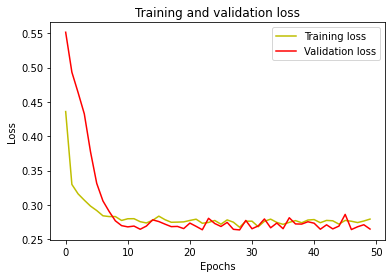

In [ ]:
plt.plot(df_treino.loc[:,'epoca'], df_treino.loc[:,'MSE'], 'y', label='Training loss')
plt.plot(df_treino.loc[:,'epoca'], df_validacao.loc[:,'valid_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

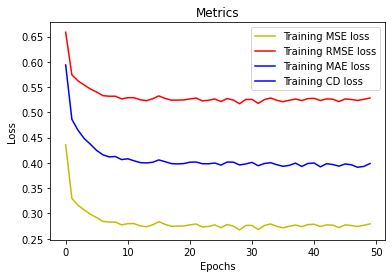

In [ ]:
plt.plot(df_treino.loc[:,'epoca'], df_treino.loc[:,'MSE'], 'y',  label='Training MSE loss')
plt.plot(df_treino.loc[:,'epoca'], df_treino.loc[:,'RMSE'], 'r', label= 'Training RMSE loss')
plt.plot(df_treino.loc[:,'epoca'], df_treino.loc[:,'MAE'], 'b',  label= 'Training MAE loss')
plt.plot(df_treino.loc[:,'epoca'], df_treino.loc[:,'CD'], 'b',   label= 'Training CD loss')
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Batch of test images
t_colunas = [
    'epoca',
    'MSE',
    'RMSE',
    'MAE'
]
df_teste = pd.DataFrame(columns=t_colunas)
i = 0
t = 0
# Fixando as coordenadas x e y para a nuvem de pontos
df_xy = pd.read_csv(FIXA_XY, sep=" ", header=None, names=["x", "y"])
df_xy = df_xy/df_xy['y'].max()
while i < len(test_loader):
  dataiter = iter(test_loader)
  images, points = dataiter.next()
  img_aux = images.clone().detach().requires_grad_(True)
  images = img_aux.reshape(BATCH_SIZE, GRAY, WIDTH, HEIGHT) # ajustar as dimensões da imagem para entrar na CNN
  # Sample outputs
  predict = model(images)

  loss_fn = criterion(predict, points)
  print(f" loss teste CDLoss = {loss_fn.item()} ")

  points_metrics_error = points.reshape([1,-1]).squeeze()
  torch.unsqueeze(points_metrics_error, 1)
  predict_metrics_error = predict.reshape([1,-1]).squeeze()
  torch.unsqueeze(predict_metrics_error, 1)
'''
  predict = predict.reshape([1,-1]).squeeze()
  predict = predict.reshape([BATCH_SIZE,NUM_POINTS])
  points = points.reshape([1,-1]).squeeze()
  points = points.reshape([BATCH_SIZE,NUM_POINTS])
'''
  print(f"Antes das metricas -- predict.shape TESTE= {predict.shape}")
  print(f"Antes das metricas -- points.shape TESTE= {points.shape}")

  MSE  = mean_squared_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy())
  RMSE = sqrt(mean_squared_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy()))
  MAE  = mean_absolute_error(predict_metrics_error.detach().numpy(), points_metrics_error.detach().numpy())
  l_MSE.append(MSE)
  l_RMSE.append(RMSE)
  l_MAE.append(MAE)
  df_teste.loc[i, 'epoca'] = e
  df_teste.loc[i, 'MSE']   = sum(l_MSE) /len(l_MSE)
  i += 1
  print(f"Antes do for  -- predict.shape TESTE= {predict.shape}")
  print(f"Antes do for -- points.shape TESTE= {points.shape}")
  for t in range(predict.shape[0]):
    z_pred  = predict[t,0:predict.shape[1]].detach().numpy()
    z_label = points[t,0:points.shape[1]].detach().numpy()
    #plt.scatter(z_pred, z_label, cmap='Blues')
    media_X = np.mean(z_pred)
    media_Y = np.mean(z_label)
    erro_X = z_pred - media_X
    erro_Y = z_label - media_Y
    soma_erro_xy = np.sum(erro_X*erro_Y)
    erro_X_quadratico = (z_pred - media_X)**2
    soma_erro_X_quadratico = np.sum(erro_X_quadratico)
    m = soma_erro_xy / soma_erro_X_quadratico
    #print("Coeficiente angular = {:0.2f}".format(m))
    c = media_Y - m * media_X
    #print("Coeficiente linear = {:0.2f}".format(c))
    reta = m*z_pred + c
    #plt.scatter(z_pred,z_label,label='Y(X)');
    plt.scatter(z_pred, z_label, cmap='Blues')
    plt.plot(z_pred,reta,label='Linear Regression',color='red');
    plt.xlabel('Z  ground truth');
    plt.ylabel('Z predict');
    plt.legend();
    nome_graf = "/content/drive/MyDrive/Minha_CNN/graficos/zpredict_zgt_" + str(t) + ".pdf"
    plt.savefig(nome_graf, format='pdf')
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.set_title('Predict vs Ground Truth')
    ax1.set_xlabel('Axis X')
    ax1.set_ylabel('Axis Y')
    ax1.set_zlabel('Axis Z')
    ax1.scatter3D(df_xy.loc[:, "x"], df_xy.loc[:, "y"], z_pred, c=z_pred, cmap='Reds', label = 'Predict Z')
    ax1.scatter3D(df_xy.loc[:, "x"], df_xy.loc[:, "y"], z_label, c=z_label, cmap='Blues', label = 'Ground Truth Z')
    nome_graf = "/content/drive/MyDrive/Minha_CNN/graficos/zpredict_zgt_3D" + str(t) + ".pdf"
    plt.savefig(nome_graf, format='pdf')
    plt.show()


  t +=1


NameError: ignored